In [ ]:
!pip install tensorflow opencv-python-headless matplotlib tensorflow_hub

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the MoveNet model from TensorFlow Hub
model_url = 'https://tfhub.dev/google/movenet/singlepose/lightning/4'
movenet = hub.load(model_url).signatures['serving_default']
input_size = 192  # Input size expected by the model


In [6]:
image_paths = ['frame1.jpg', 'frame2.jpg']  # Replace with actual video frame paths
processed_images = []
all_keypoints_data = {}

# Define keypoint connection edges for visualization
KEYPOINT_EDGES = [
    (0, 1), (0, 2), (1, 3), (2, 4),
    (5, 6), (5, 7), (7, 9), (6, 8), (8, 10),
    (5, 11), (6, 12), (11, 12),
    (11, 13), (13, 15), (12, 14), (14, 16)
]

# Helper function for drawing keypoints and edges
def draw_prediction_on_image(image, keypoints_with_scores, confidence_threshold=0.2):
    image_copy = np.copy(image)
    keypoints = keypoints_with_scores[0, 0, :, :2]
    scores = keypoints_with_scores[0, 0, :, 2]
    height, width, _ = image.shape

    for i in range(keypoints.shape[0]):
        if scores[i] >= confidence_threshold:
            y, x = keypoints[i]
            cv2.circle(image_copy, (int(x * width), int(y * height)), 4, (0, 255, 0), -1)

    for edge in KEYPOINT_EDGES:
        start_idx, end_idx = edge
        if scores[start_idx] >= confidence_threshold and scores[end_idx] >= confidence_threshold:
            y_start, x_start = keypoints[start_idx]
            y_end, x_end = keypoints[end_idx]
            cv2.line(image_copy,
                     (int(x_start * width), int(y_start * height)),
                     (int(x_end * width), int(y_end * height)),
                     (0, 255, 0), 2)
    return image_copy


In [7]:
# Dummy timestamps (e.g., 30 FPS video)
timestamps = [0.0, 0.033]

for i, image_path in enumerate(image_paths):
    try:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Could not read image {image_path}. Skipping.")
            continue
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"Error reading {image_path}: {e}")
        continue

    # Resize and pad to input size
    input_image = tf.image.resize_with_pad(tf.expand_dims(image_rgb, axis=0), input_size, input_size)
    input_image = tf.cast(input_image, dtype=tf.int32)

    # Run inference
    outputs = movenet(input_image)
    keypoints_with_scores = outputs['output_0'].numpy()

    # Step 4: Store keypoints with timestamps
    all_keypoints_data[image_path] = {
        'keypoints': keypoints_with_scores,
        'timestamp': timestamps[i]
    }

    # Step 6: Prepare for visualization
    display_image = draw_prediction_on_image(image_rgb, keypoints_with_scores)
    processed_images.append(display_image)


In [8]:
# Analyze motion between frame1 and frame2
if len(all_keypoints_data) == 2:
    kp1 = all_keypoints_data['frame1.jpg']['keypoints'][0, 0, :, :2]
    kp2 = all_keypoints_data['frame2.jpg']['keypoints'][0, 0, :, :2]

    movement = np.linalg.norm(kp2 - kp1, axis=1)
    print("\nKeypoint movement between frames:")
    for i, dist in enumerate(movement):
        print(f"Keypoint {i}: Movement = {dist:.4f}")



Keypoint movement between frames:
Keypoint 0: Movement = 0.1733
Keypoint 1: Movement = 0.2093
Keypoint 2: Movement = 0.1923
Keypoint 3: Movement = 0.1554
Keypoint 4: Movement = 0.2173
Keypoint 5: Movement = 0.0676
Keypoint 6: Movement = 0.1899
Keypoint 7: Movement = 0.1157
Keypoint 8: Movement = 0.1911
Keypoint 9: Movement = 0.0769
Keypoint 10: Movement = 0.1401
Keypoint 11: Movement = 0.0606
Keypoint 12: Movement = 0.0204
Keypoint 13: Movement = 0.1620
Keypoint 14: Movement = 0.1083
Keypoint 15: Movement = 0.1931
Keypoint 16: Movement = 0.1597


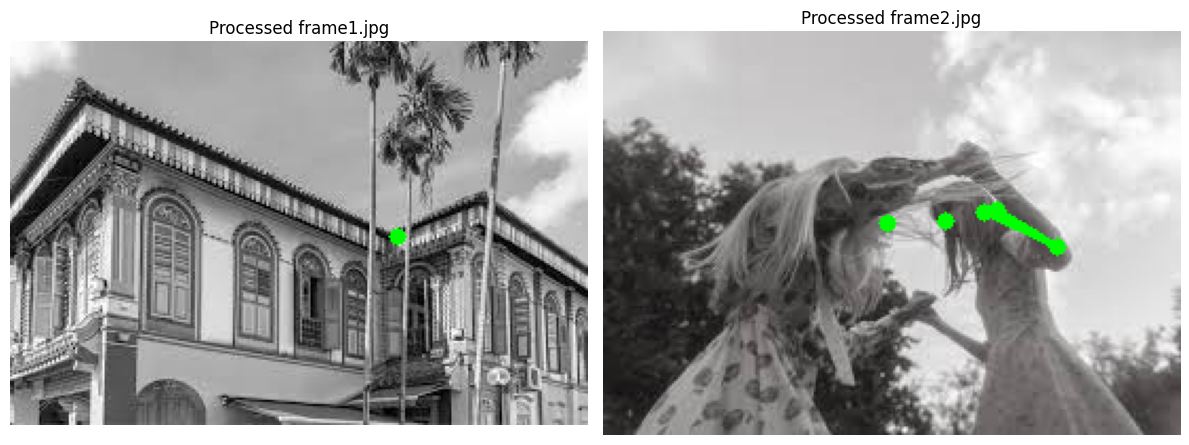

In [9]:
# Display all processed images
if processed_images:
    plt.figure(figsize=(12, 6 * len(processed_images) // 2))
    for i, img in enumerate(processed_images):
        plt.subplot(1, len(processed_images), i + 1)
        plt.imshow(img)
        plt.title(f'Processed {image_paths[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No images were processed successfully.")


#Conclusion

rocessed frame1.jpg (Building):

Observation: The model detected keypoints and drew a partial skeleton on one of the palm trees.

Evaluation: This is incorrect. MoveNet is designed for human pose estimation. Detecting a pose on a tree is a false positive. It demonstrates that the model might identify patterns in non-human objects that it interprets as a human pose, especially when no clear human subject is present.

Improvement Needed: This highlights a limitation of applying the model directly without context or filtering. You might need pre-processing to detect humans first, or post-processing to filter out detections with low overall confidence scores, which might indicate a non-human object.

Processed frame2.jpg (Two People):

Observation: The model correctly identified and drew keypoints/skeleton parts on one of the two people visible in the frame.

Evaluation: This is correct behavior for the specific model used (movenet/singlepose/lightning). This model version is explicitly designed to detect only one person (typically the most prominent or centrally located one). It successfully did that.

Improvement Needed (if goal is different): If the objective was to detect all people in the frame, the singlepose model is insufficient. You would need to switch to a multi-pose estimation model, such as movenet/multipose/lightning.

Conclusion:

The code is correct in terms of executing the steps: loading the model, processing the images, running inference, and visualizing the output.

The results need improvement or reconsideration:

The false positive in frame1.jpg shows a need for careful application or filtering.

The single detection in frame2.jpg is expected for the chosen model but might require using a multipose model if detecting all subjects is the goal.

The second image provided (the scatter plot) appears to be from the earlier simulation step and is not relevant to the evaluation of the code running on frame1.jpg and frame2.jpg.